[View in Colaboratory](https://colab.research.google.com/github/tbonza/ds5220/blob/master/quick_draw1.ipynb)

# Summary

Reference: [Kaggle, Image-Based CNN](https://www.kaggle.com/jpmiller/image-based-cnn)

# Install Packages and Load Data Sample

We want to take an initial first look at the data and see how to work with the image data.

In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [64]:
!pip install dask
!pip install cloudpickle

In [0]:
import ast
import io
import os
import zipfile

from dask import bag
import pandas as pd
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

%matplotlib inline

In [0]:
fpath = "gdrive/My Drive/gcolab/train_simplified.zip"

In [15]:
with zipfile.ZipFile(fpath) as myzip:
  with myzip.open('trombone.csv') as myfile:
    data_trombone = myfile.read()
  print(myzip.namelist()[:5])

['fence.csv', 'yoga.csv', 'horse.csv', 'sandwich.csv', 'cat.csv']


In [0]:
cnames = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

df = pd.read_csv(io.StringIO(data_trombone.decode("utf-8")))
df.columns = cnames

In [30]:
df.shape

(184759, 6)

In [31]:
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,US,"[[[225, 218, 211, 197, 191, 185, 187, 194, 209...",4910981694095360,True,2017-03-25 01:09:19.281480,trombone
1,ID,"[[[35, 185, 209, 231, 237, 237, 222, 201, 137,...",6122256692412416,True,2017-03-28 12:46:12.440900,trombone
2,US,"[[[118, 113, 114, 120, 127, 134, 137, 141, 133...",5020720214048768,True,2017-04-03 16:56:01.955510,trombone
3,IT,"[[[0, 25, 102, 149, 255, 255], [69, 51, 25, 3,...",4928415318671360,False,2017-03-03 20:17:01.648820,trombone
4,US,"[[[4, 33, 200, 207, 206, 182, 166, 137, 12, 3,...",5824340362788864,True,2017-03-06 05:40:02.469670,trombone


# Plotting Images

In [0]:
def plot_images(df, start, end):
  
  example1s = [ast.literal_eval(pts) for pts in df.drawing.values]
  labels = df.word.tolist()
  
  i = 0
  for example in example1s[start:end]:
  
    plt.figure(figsize=(6,3))
    
    for x,y in example:
      plt.subplot(1,2,1)
      plt.plot(x, y, marker='.')
      plt.axis('off')
      plt.title(labels[start + i], fontsize=10)
      
      i += 1
      
  return plt

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

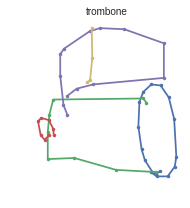

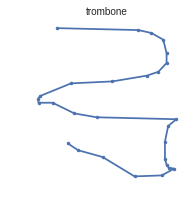

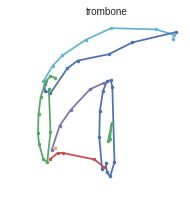

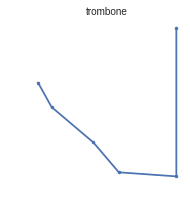

In [56]:
plot_images(df, 0, 4)

# Making a Prediction

In [0]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

In [95]:
print(classfiles[0])

train_grand = []
with zipfile.ZipFile(fpath) as myzip:
  
  classfiles = myzip.namelist()
  numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)}
  
  for i, c in enumerate(tqdm(classfiles[0:num_classes])):
    with myzip.open(c) as myfile:
   
      train = pd.read_csv(io.StringIO(myfile.read().decode("utf-8")), 
                          usecols=['drawing', 'recognized'], 
                          nrows=ims_per_class*5//4)
      train = train[train.recognized == True].head(ims_per_class)
      imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
      trainarray = np.array(imagebag.compute())  # PARALLELIZE
      trainarray = np.reshape(trainarray, (ims_per_class, -1))
      labelarray = np.full((train.shape[0], 1), i)
      trainarray = np.concatenate((labelarray, trainarray), axis=1)
      train_grand.append(trainarray)
      
#less memory than np.concatenate
      
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) 
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

  0%|          | 0/340 [00:00<?, ?it/s]

fence.csv


100%|██████████| 340/340 [14:29<00:00,  2.82s/it]


In [0]:
del trainarray
del train

In [97]:
# memory-friendly alternative to train_test_split?
valfrac = 0.1
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_val = keras.utils.to_categorical(y_val, num_classes)
X_val = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape)

(612000, 340) 
 (612000, 32, 32, 1) 
 (68000, 340) 
 (68000, 32, 32, 1)


In [98]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(imheight, imwidth, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(680, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 680)               2785960   
__________

In [0]:
def top_3_accuracy(x,y): 
    t3 = top_k_categorical_accuracy(x,y, 3)
    return t3

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, 
                                   verbose=1, mode='auto', min_delta=0.005, cooldown=5, min_lr=0.0001)
earlystop = EarlyStopping(monitor='val_top_3_accuracy', mode='max', patience=5) 
callbacks = [reduceLROnPlat, earlystop]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', top_3_accuracy])

model.fit(x=X_train, y=y_train,
          batch_size = 32,
          epochs = 22,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          verbose = 1)

Train on 612000 samples, validate on 68000 samples
Epoch 1/22
612000/612000 [==============================] - 2308s 4ms/step - loss: 3.0953 - acc: 0.3048 - top_3_accuracy: 0.4942 - val_loss: 2.2168 - val_acc: 0.4689 - val_top_3_accuracy: 0.6799
Epoch 2/22
612000/612000 [==============================] - 2334s 4ms/step - loss: 2.5363 - acc: 0.3969 - top_3_accuracy: 0.6087 - val_loss: 2.0688 - val_acc: 0.5017 - val_top_3_accuracy: 0.7112
Epoch 3/22
482848/612000 [======================>.......] - ETA: 8:04 - loss: 2.4007 - acc: 0.4220 - top_3_accuracy: 0.6360Buffered data was truncated after reaching the output size limit.

In [0]:
print("hello")